In [1]:
import numpy as np
import pandas as pd
import time

## Reading Features

In [2]:
#PRS = np.load('PRS.npy')
FE = np.load('FE.npy')
labels = np.load('LOS.npy')
#cor = np.load('cor.npy')
#RX = np.load('RX_time.npy')
#RX = np.stack((np.abs(RX), np.angle(RX)), axis = -2)
#print(f'RX shape = {RX.shape}\ncorrelation shape = {cor.shape}\nstatistical feature shape = {FE.shape},\nLOS = {np.unique(labels, return_counts=True)}')
print(f'statistical feature shape = {FE.shape},\nLOS/NLOS labels = {np.unique(labels, return_counts=True)}')

statistical feature shape = (7102, 5, 6),
LOS/NLOS labels = (array([0, 1]), array([6677,  425]))


In [189]:
import seaborn as sns


import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.decomposition import KernelPCA, PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, LearningCurveDisplay, ShuffleSplit, RandomizedSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, f1_score, average_precision_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Preprocessing Data
### Investigating transformation for dimention reduction
Dimention reduction techniques are usually based on eigen value and eigen vector decomposition. By doing this analysis, we can find that if lower numebr of features are able to explain feature variances or not. If so, a linear or non-linear dimenionality reduction technique such as PCA or LDA can be considered. 

In addition, the initial train/test split is build in this section. other preprocessing requirements sucha as scaling the data will be performed inside the pipelines

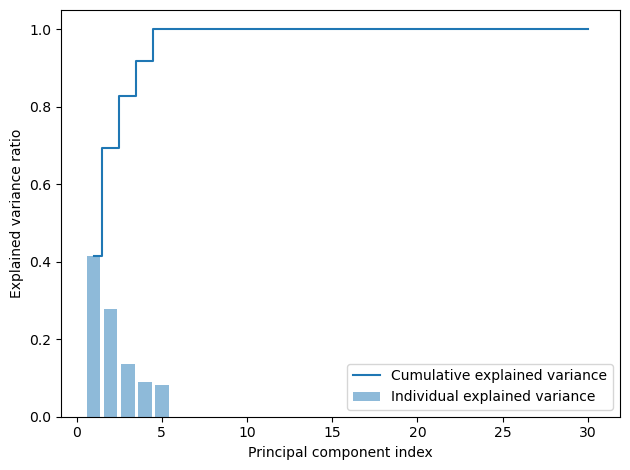

In [4]:
X = FE.reshape(FE.shape[0], -1)
cov_mat = np.cov(X.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, X.shape[1]+1), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, X.shape[1]+1), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()

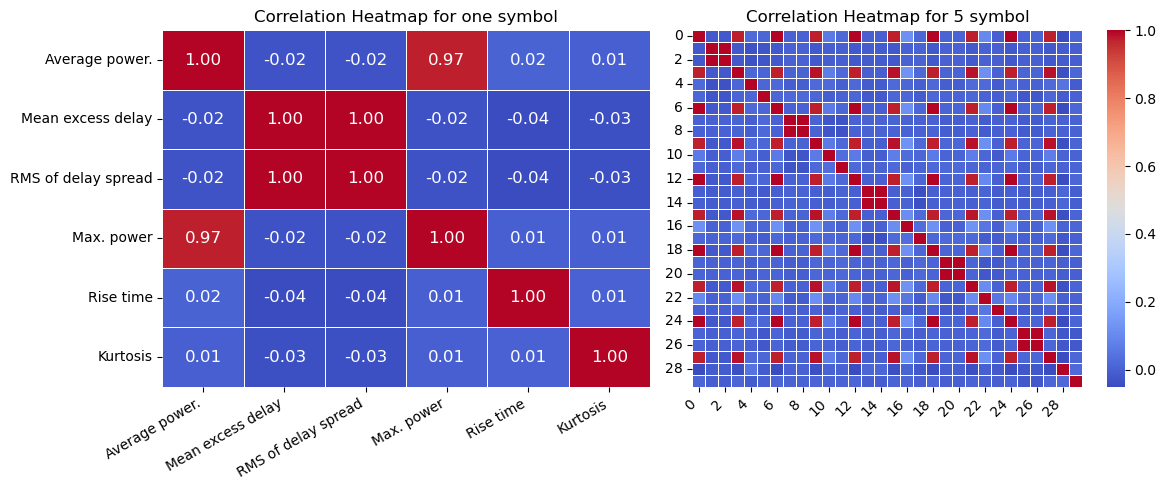

In [5]:
# Calculate the correlation matrix
correlation_matrix = np.corrcoef(X[:,:], rowvar=False)
correlation_labels = ["Average power.", "Mean excess delay", "RMS of delay spread", "Max. power", "Rise time", "Kurtosis"]
# Create a heatmap to visualize the correlation matrix

# Create a mask to display only half of the correlation matrix

# Create a heatmap to visualize the correlation matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(correlation_matrix[:6,:6], annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", cbar=False, annot_kws={"size": 12, "va": "center", "ha": "center"}, ax=axes[0])
axes[0].set_xticklabels(correlation_labels, rotation=30, horizontalalignment='right')
axes[0].set_yticklabels(correlation_labels, rotation=0, va='center')  # Set custom y-axis labels
axes[0].set_title('Correlation Heatmap for one symbol')

sns.heatmap(correlation_matrix[:,:], annot=False, cmap='coolwarm', linewidths=0.5, fmt=".2f", cbar=True, annot_kws={"size": 12, "va": "center", "ha": "center"}, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, va='center')  # Set custom y-axis labels if needed
axes[1].set_title('Correlation Heatmap for 5 symbol')

plt.tight_layout()
plt.show()

In [6]:
ind = np.array([0, 1, 4, 5, 0+6, 1+6, 4+6, 5+6, 0+12, 1+12, 4+12, 5+12, 0+18, 1+18, 4+18, 5+18, 0+24, 1+24, 4+24, 5+24])
XX = X[:,ind]
XX.shape

(7102, 20)

In [7]:
# Remove correlated statistical features (Even coulmns)
df = pd.DataFrame(XX)
df.columns
df.iloc[:,:8].describe()

,0,1,2,3,4,5,6,7
count,7102.000000,7102.000000,7102.000000,7.102000e+03,7102.000000,7102.000000,7102.000000,7.102000e+03
mean,0.000012,0.017058,8.331390,1.172447e+03,0.000012,0.017058,19.890376,1.172447e+03
std,0.000008,0.000115,20.935302,7.295290e-09,0.000008,0.000114,45.837967,7.521404e-09
min,0.000002,0.016648,-205.454926,1.172447e+03,0.000002,0.016602,-141.047647,1.172447e+03
25%,0.000007,0.016982,0.000000,1.172447e+03,0.000007,0.016981,0.000000,1.172447e+03
50%,0.000009,0.017056,0.000000,1.172447e+03,0.000009,0.017058,0.000000,1.172447e+03
75%,0.000013,0.017136,4.730410,1.172447e+03,0.000013,0.017135,8.098704,1.172447e+03
max,0.000064,0.017475,276.589569,1.172447e+03,0.000064,0.017538,403.140930,1.172447e+03


## Naive Random serach for best pipeline
In this section, we are looking for an initial architecture with a proper performance in terms of accuracy and roc-auc to use it as a baseline for learning transformer hyper parameters. To do so, a RandomizedSearch with 10 fold stratified cross validation is used. 
[Cross validation procedure to avoid overfitting](https://scikit-learn.org/stable/_images/grid_search_workflow.png) <br> <br>
<div style="text-align:center;">
<a href="https://scikit-learn.org">
    <img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width="500" height="300">
</a>
</div>



In [8]:
X_train, X_test, y_train, y_test = train_test_split(XX, labels, test_size=0.2, random_state=42, stratify=labels)

In [365]:
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'Normalizer': Normalizer(),
}

transformers = {
    'PCA': PCA(n_components=None),  
    'KernelPCA': KernelPCA(n_components=None),  
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
    'TruncatedSVD': TruncatedSVD()

}

estimators = {
    #classic estimators
    'LogisticRegression': LogisticRegression(max_iter=200),
    'SVM': SVC(probability=True),
    'SGD': SGDClassifier(loss = 'log_loss'),
    'KNN': KNeighborsClassifier(),
    #'RadiusNeighbhborsClassifier': RadiusNeighborsClassifier(),
    'NaiveBayes': GaussianNB(), 
    #boosting / ensemble estimators 
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    #Classic MLP, carried on on Scikit learn
    'MLP': MLPClassifier(hidden_layer_sizes=(50,50,50), activation='relu', solver='adam', alpha=0.0001, max_iter=1000, random_state=42), 
}
param_grids = {
        'scaler': list(scalers.values()),
        'transformer': list(transformers.values()),
        'estimator': list(estimators.values())
    }

pipeline = Pipeline([
    ('scaler', None),
    ('transformer', None),
    ('estimator', None)
])

n_splits = 10
stratified_kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
scoring = {"AUC": "roc_auc", 'f1': 'f1'}
#random_search = RandomizedSearchCV(
#    estimator=pipeline,
#    param_distributions = param_grids,
#    n_iter = 10,
#    cv = stratified_kf,
#    n_jobs = -1,
#    verbose = 1,
#    random_state = 2561,
#    scoring = scoring,
#    refit= 'AUC'
#)
#random_search.fit(X_train, y_train)

search = GridSearchCV(estimator = pipeline, param_grid = param_grids, cv = 5, n_jobs = -1, verbose = 1, scoring = scoring, refit= 'AUC', return_train_score=True)
search.fit(X_train, y_train)

# Get the best parameters for each step
#best_scaler = random_search.best_params_['scaler']
#best_transformer = random_search.best_params_['transformer']
#best_estimator = random_search.best_params_['estimator']
# Now you can use the best parameters to construct the final pipeline
#final_pipeline = Pipeline([
#    ('scaler', best_scaler),
#    ('transformer', best_transformer),
#    ('estimator', best_estimator)
#])
# Fit the final pipeline to the training data
#final_pipeline.fit(X_train, y_train)
#final_pipeline

Fitting 5 folds for each of 176 candidates, totalling 880 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', None), ('transformer', None),
                                       ('estimator', None)]),
             n_jobs=-1,
             param_grid={'estimator': [LogisticRegression(max_iter=200),
                                       SVC(probability=True),
                                       SGDClassifier(loss='log_loss'),
                                       KNeighborsClassifier(), GaussianNB(),
                                       DecisionTreeClassifier(),
                                       RandomForestClassifier(),
                                       GradientBoostingClassifier(),
                                       ExtraTreesClassifier(),
                                       AdaBoostClassifier(),
                                       MLPClassifier(hidden_layer_sizes=(50, 50,
                                                                         50),
                                                     max_iter=1000,
                                                     random_state=42)],
                         'scaler': [StandardScaler(), MinMaxScaler(),
                                    RobustScaler(), Normalizer()],
                         'transformer': [PCA(), KernelPCA(),
                                         LinearDiscriminantAnalysis(),
                                         TruncatedSVD()]},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'f1': 'f1'}, verbose=1)

In [366]:
print(search.cv_results_.keys())
scores = search.cv_results_['rank_test_AUC']
param_sets = search.cv_results_['params']

# Find the indices that would sort the scores in descending order
sorted_indices = np.argsort(scores)
#Get the 5 best parameter sets and their corresponding scores
best_param_sets = [param_sets[i] for i in sorted_indices[:50]]
best_scores = [scores[i] for i in sorted_indices[:50]]
# Print the best parameter sets and scores
for i, (params, score) in enumerate(zip(best_param_sets, best_scores)):
    print(f"Rank {i + 1}: Parameters: {params}, Rank (based on AUC test): {score:.0f}")


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_estimator', 'param_scaler', 'param_transformer', 'params', 'split0_test_AUC', 'split1_test_AUC', 'split2_test_AUC', 'split3_test_AUC', 'split4_test_AUC', 'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC', 'split0_train_AUC', 'split1_train_AUC', 'split2_train_AUC', 'split3_train_AUC', 'split4_train_AUC', 'mean_train_AUC', 'std_train_AUC', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_train_f1', 'split1_train_f1', 'split2_train_f1', 'split3_train_f1', 'split4_train_f1', 'mean_train_f1', 'std_train_f1'])
Rank 1: Parameters: {'estimator': LogisticRegression(max_iter=200), 'scaler': RobustScaler(), 'transformer': PCA()}, Rank (based on AUC test): 1
Rank 2: Parameters: {'estimator': LogisticRegression(max_iter=200), 'scaler': RobustScaler(), 'transformer': KernelPCA()}, Rank (based on AUC test): 1
Rank 3: Par

In [367]:
unique_classifiers = set()
selected_pipes = []
for item in best_param_sets:
    classifier = item['estimator']
    if classifier not in unique_classifiers:
        unique_classifiers.add(classifier)
        selected_pipes.append(item)

top_pipelines = [Pipeline([
    ('scaler', pipe['scaler']),
    ('transformer', pipe['transformer']),
    ('estimator', pipe['estimator'])
]) for pipe in selected_pipes]
top_pipelines

[Pipeline(steps=[('scaler', RobustScaler()), ('transformer', PCA()),
                 ('estimator', LogisticRegression(max_iter=200))]),
 Pipeline(steps=[('scaler', MinMaxScaler()), ('transformer', KernelPCA()),
                 ('estimator', SGDClassifier(loss='log_loss'))]),
 Pipeline(steps=[('scaler', MinMaxScaler()), ('transformer', TruncatedSVD()),
                 ('estimator',
                  MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=1000,
                                random_state=42))]),
 Pipeline(steps=[('scaler', MinMaxScaler()), ('transformer', TruncatedSVD()),
                 ('estimator', SVC(probability=True))]),
 Pipeline(steps=[('scaler', MinMaxScaler()), ('transformer', PCA()),
                 ('estimator', ExtraTreesClassifier())]),
 Pipeline(steps=[('scaler', MinMaxScaler()), ('transformer', KernelPCA()),
                 ('estimator', GradientBoostingClassifier())]),
 Pipeline(steps=[('scaler', MinMaxScaler()), ('transformer', TruncatedSVD()),
 

### Investigating top pipeline performance

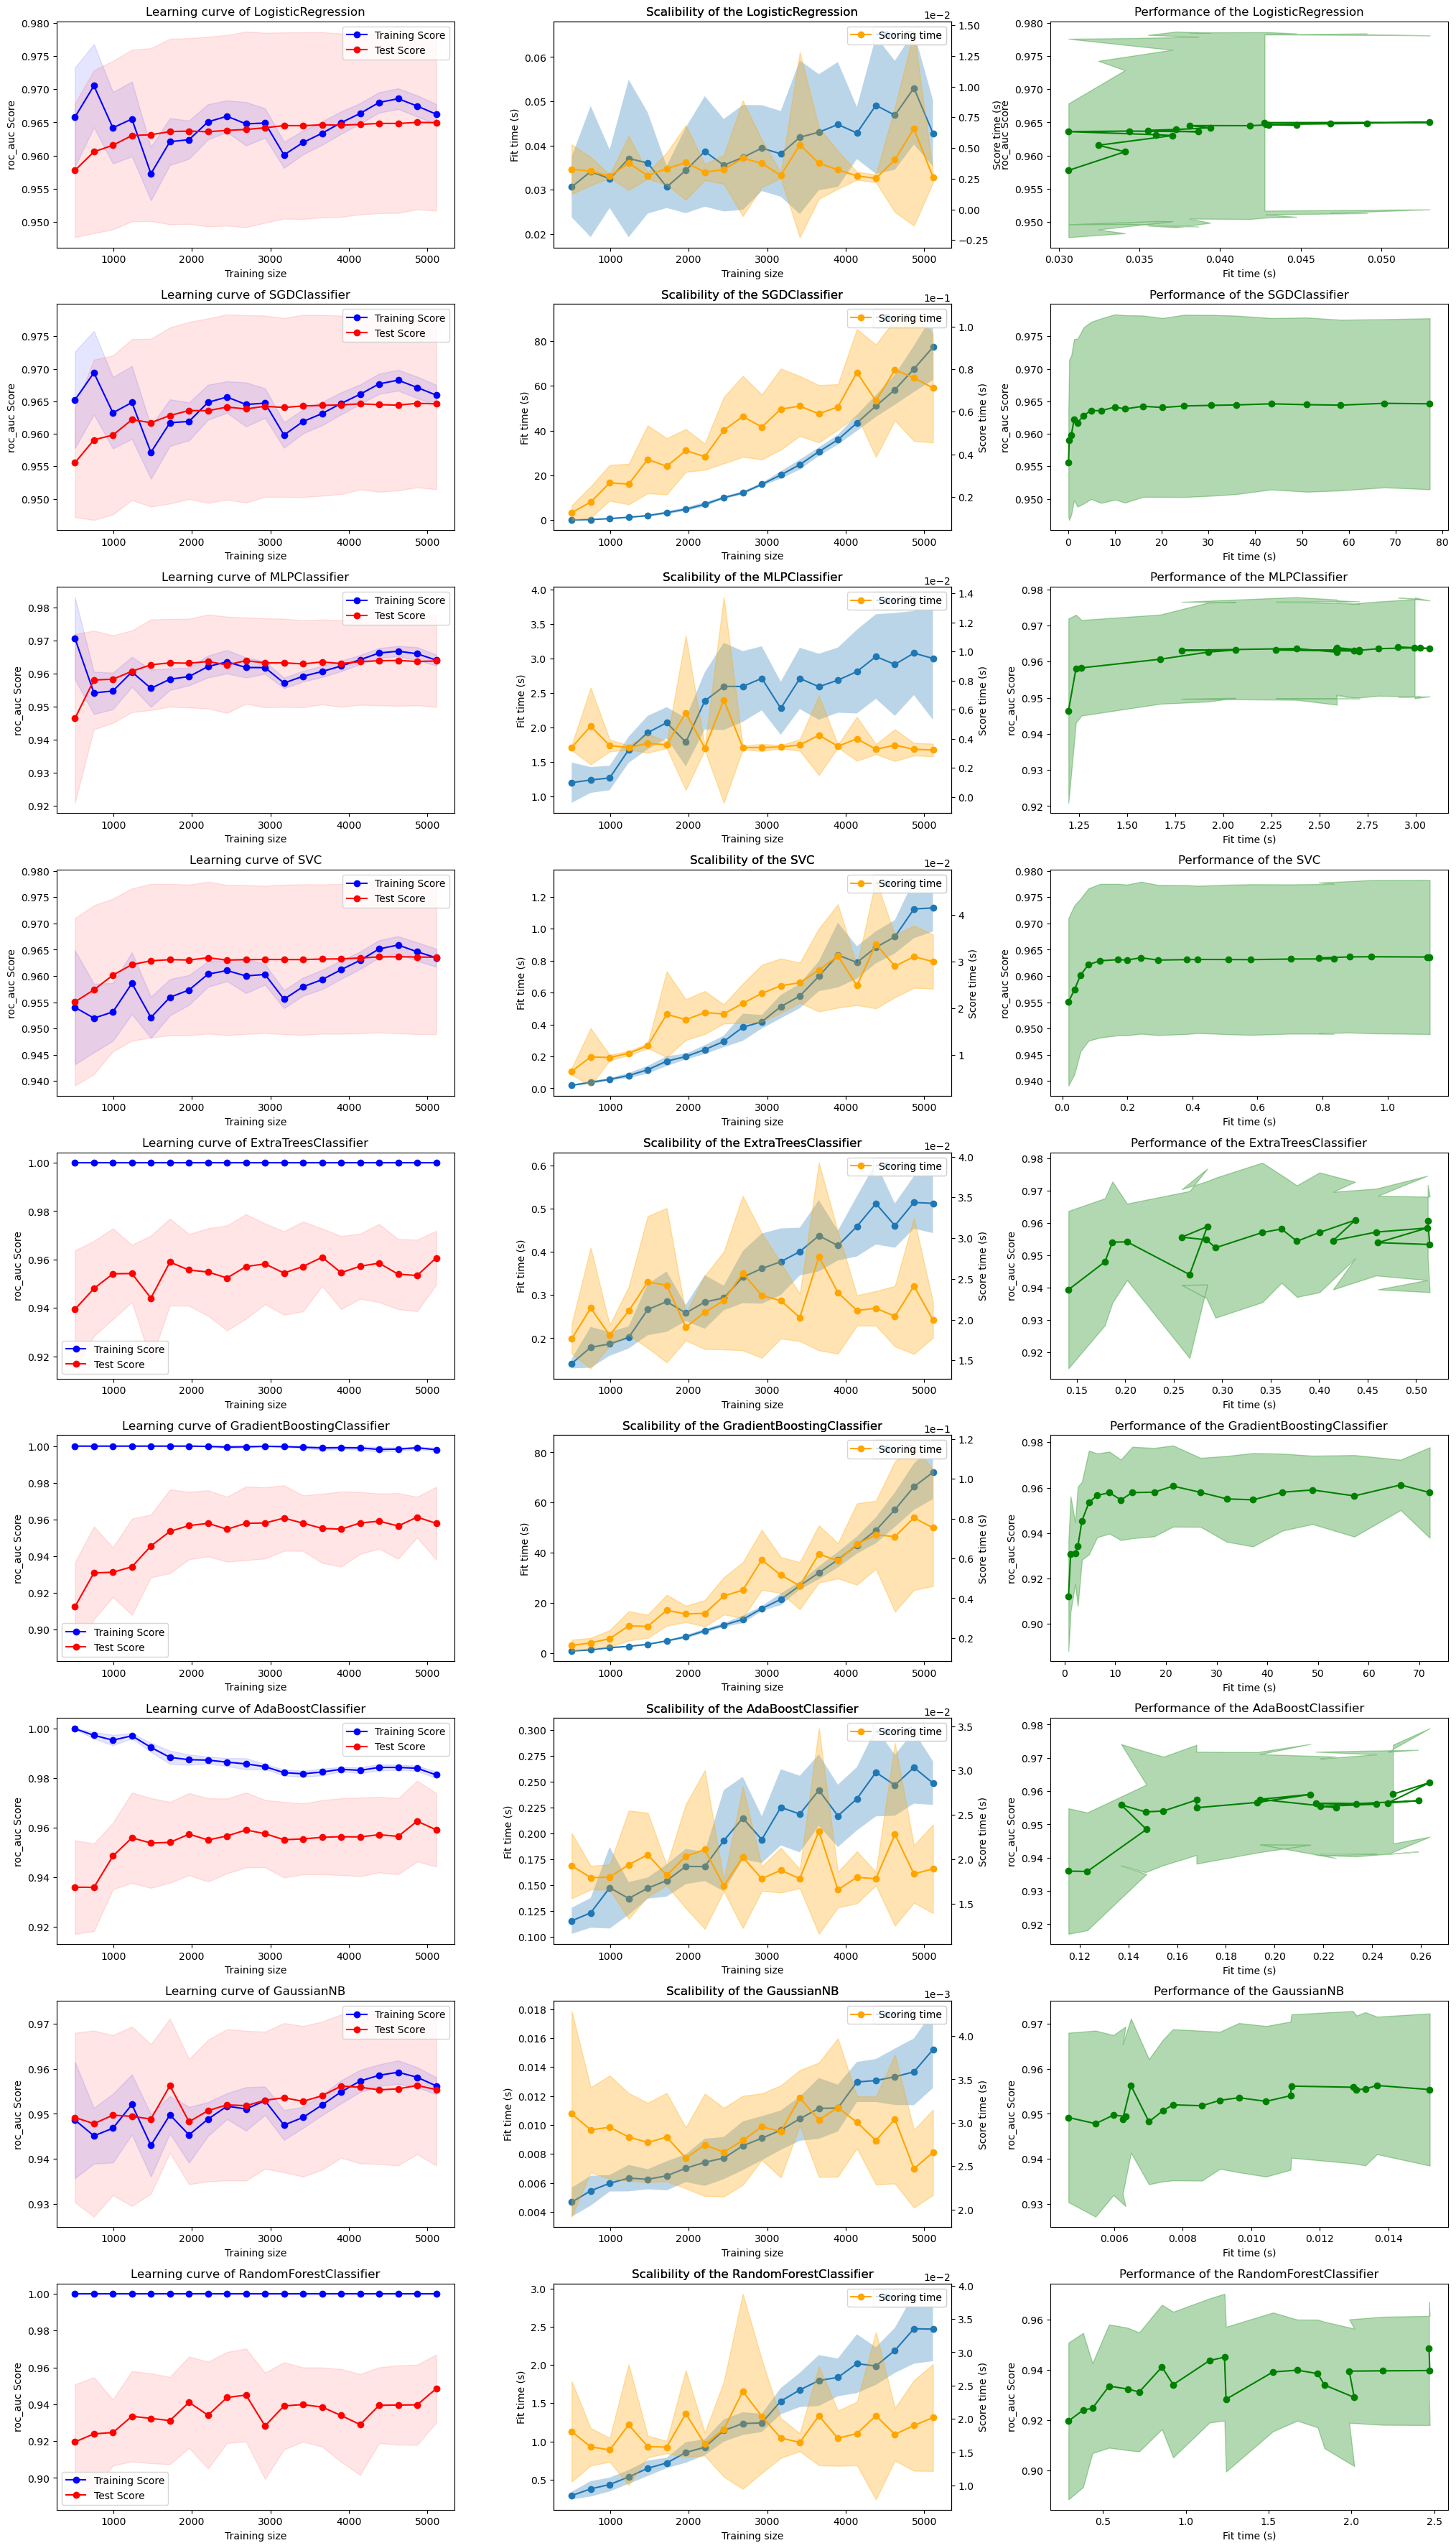

In [368]:
n_splits = 10
common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 20),
    "cv": StratifiedKFold(n_splits= n_splits, shuffle=True, random_state=42),
    "n_jobs": -1,
    #"line_kw": {"marker": "o"},
    #"std_display_style": "fill_between",
    "scoring": "roc_auc",
    'return_times': True, 
}

class_names = ['LOS', 'NLOS']


fig, ax = plt.subplots(nrows=len(top_pipelines), ncols=3, figsize=(25, 45))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
for ax_idx, pipeline in enumerate(top_pipelines):
# Learning curve for top 5 pipelines
    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(pipeline, **common_params, verbose = 0)
    
    # Calculate the mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    

    # Plot training and test scores
    ax[ax_idx][0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="b")
    ax[ax_idx][0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="r")
    ax[ax_idx][0].plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training Score")
    ax[ax_idx][0].plot(train_sizes, test_scores_mean, 'o-', color="r", label="Test Score")
    ax[ax_idx][0].legend(loc="best")
    
    est_name = pipeline.named_steps['estimator'].__class__.__name__
    ax[ax_idx][0].set_title(f'Learning curve of {est_name}')
    ax[ax_idx][0].set_xlabel("Training size")
    ax[ax_idx][0].set_ylabel(f"{common_params['scoring']} Score")


# scalability regarding the fit time
    ax[ax_idx][1].plot(train_sizes, fit_times.mean(axis=1), "o-", label="Fit time")
    ax[ax_idx][1].fill_between(
        train_sizes,
        fit_times.mean(axis=1) - fit_times.std(axis=1),
        fit_times.mean(axis=1) + fit_times.std(axis=1),
        alpha=0.3,
    )
    ax[ax_idx][1].set_xlabel("Training size")
    ax[ax_idx][1].set_ylabel("Fit time (s)")
    ax[ax_idx][1].set_title(f'Scalibility of the {est_name}')
    ax[ax_idx][1].legend(loc="best")

# scalability regarding the score time
    axx = ax[ax_idx][1].twinx()
    axx.plot(train_sizes, score_times.mean(axis=1), "o-", color = 'orange', label="Scoring time")
    axx.fill_between(
        train_sizes,
        score_times.mean(axis=1) - score_times.std(axis=1),
        score_times.mean(axis=1) + score_times.std(axis=1),
        alpha=0.3, color = 'orange'
    )
    axx.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) 
    axx.set_xlabel("Training size")
    axx.set_ylabel("Score time (s)")
    axx.set_title(f'Scalibility of the {est_name}')
    axx.legend(loc="best")

# Pipeline performance based to test score 
    ax[ax_idx][2].plot(fit_times.mean(axis=1), test_scores.mean(axis=1), "o-", color="g")
    ax[ax_idx][2].fill_between(
        fit_times.mean(axis=1),
        test_scores.mean(axis=1) - test_scores.std(axis=1),
        test_scores.mean(axis=1) + test_scores.std(axis=1),
        alpha=0.3, color="g"
    )
    ax[ax_idx][2].set_ylabel(f"{common_params['scoring']} Score")
    ax[ax_idx][2].set_xlabel("Fit time (s)")
    ax[ax_idx][2].set_title(
        f"Performance of the {est_name}"
    )
#LearningCurveDisplay.from_estimator(pipeline, **common_params, ax=ax[ax_idx, 0])
#handles, label = ax[ax_idx, 0].get_legend_handles_labels()
#ax[ax_idx][0].legend(handles[:2], ["Training Score", "Test Score"])
#est_name = pipeline.named_steps['estimator'].__class__.__name__
#ax[ax_idx][0].set_title(est_name)



### Find the optimum Threshold based on 10-fold cross validatio and visualizing ROC curve and confusion matrix

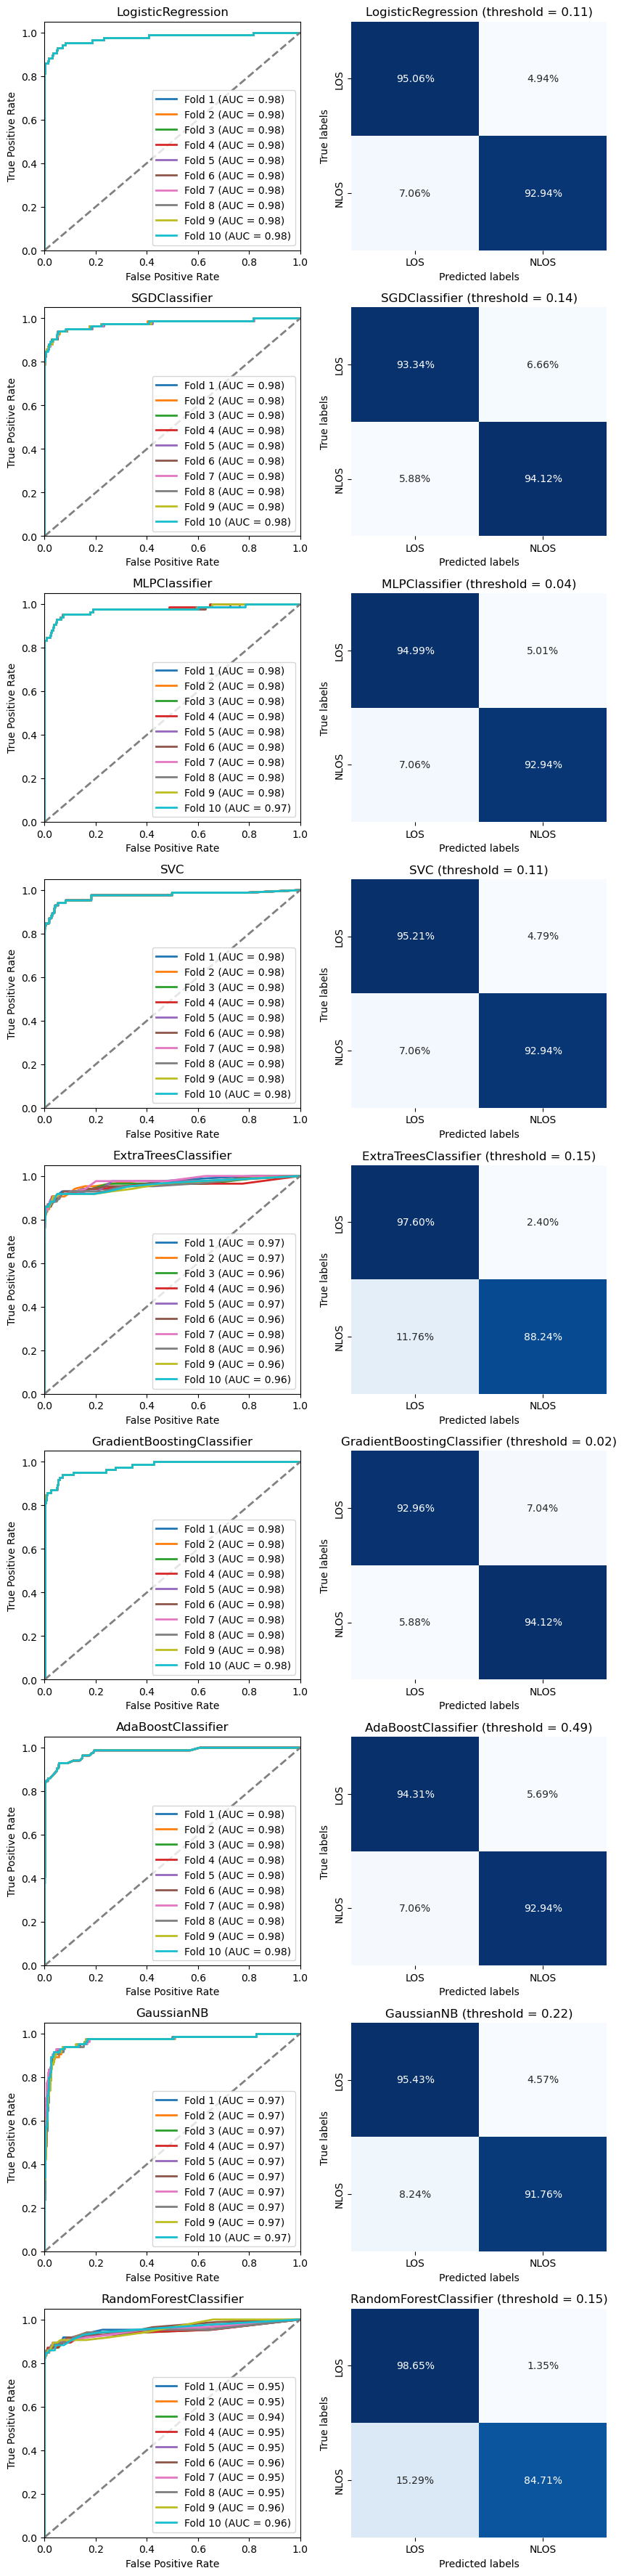

In [369]:
fig, ax = plt.subplots(nrows=len(top_pipelines), ncols=2, figsize=(10, 45))
plt.subplots_adjust(hspace=0.25)
for ax_idx, pipeline in enumerate(top_pipelines):
#ROC curve for top 5 pipelines
    all_fpr = []
    all_tpr = []
    all_auc = []
    all_threshold = []
    # Create an instance of StratifiedKFold with 10 folds
    n_splits = 10
    for fold, (train_index, test_index) in enumerate(stratified_kf.split(X_train, y_train)):
        XX_train, XX_test = XX[train_index], XX[test_index]
        yy_train, yy_test = labels[train_index], labels[test_index]
    
    # Fit the pipeline on the training data for the current fold
        pipeline.fit(X_train, y_train)
    
    # Get the predicted probabilities for the positive class
        y_prob = pipeline.predict_proba(X_test)
    
    # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1], drop_intermediate = True)

        optimal_threshold_index = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_threshold_index]
    # Calculate AUC
        roc_auc_fold = auc(fpr, tpr)

    # Store ROC data for this fold
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        all_auc.append(roc_auc_fold)
        all_threshold.append(optimal_threshold)
        est_name = pipeline.named_steps['estimator'].__class__.__name__

    # Plot the ROC curves for each fold
    for fold in range(n_splits):
        ax[ax_idx][0].plot(all_fpr[fold], all_tpr[fold], lw=2, label=f'Fold {fold+1} (AUC = {all_auc[fold]:.2f})')

    ax[ax_idx][0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax[ax_idx][0].set_xlim([0.0, 1.0])
    ax[ax_idx][0].set_ylim([0.0, 1.05])
    ax[ax_idx][0].set_xlabel('False Positive Rate')
    ax[ax_idx][0].set_ylabel('True Positive Rate')
    ax[ax_idx][0].set_title(f'{est_name}')
    ax[ax_idx][0].legend(loc='lower right')

#COnfusion matrix based based on optimal threshold
    custom_threshold = np.mean(all_threshold)
    y_pred = (y_prob[:, 1] >= custom_threshold).astype(int)  # Assuming binary classification
    cm = confusion_matrix(y_test, y_pred, normalize = 'true')
    sns.heatmap(cm, annot=True,  cbar = False, cmap="Blues", fmt=".2%", xticklabels=class_names, yticklabels=class_names, ax = ax[ax_idx, 1])
    ax[ax_idx, 1].set_xlabel("Predicted labels")
    ax[ax_idx, 1].set_ylabel("True labels")
    ax[ax_idx, 1].set_title(f'{est_name} (threshold = {custom_threshold:.2f})')
    

In [338]:
# Create a voting classifier with 'soft' voting
estimators = [('pipe' + str(i+1), top_pipelines[i]) for i in range(5)]
voting_classifier = VotingClassifier(estimators= estimators, voting='soft')
# Fit the ensemble model
voting_classifier.fit(X_train, y_train)

# Make predictions
y_pred = voting_classifier.predict(X_test)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the Voting Classifier:", accuracy)


Accuracy of the Voting Classifier: 0.9859254046446164


<Axes: >

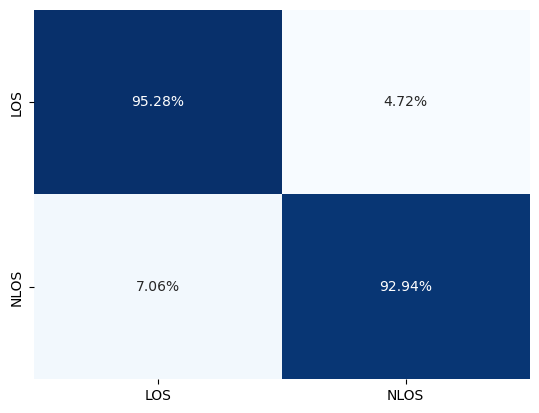

In [339]:
y_prob = voting_classifier.predict_proba(X_test)
    
    # Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1], drop_intermediate = True)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]
    # Calculate AUC
y_pred = (y_prob[:, 1] >= optimal_threshold).astype(int)  # Assuming binary classification
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(cm, annot=True,  cbar = False, cmap="Blues", fmt=".2%", xticklabels=class_names, yticklabels=class_names)


In [341]:

# Create the StackingClassifier
stacking_classifier = StackingClassifier(estimators=estimators[1:], final_estimator=DecisionTreeClassifier())

# Fit the StackingClassifier on the training data
stacking_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = stacking_classifier.predict(X_test)

# Evaluate the performance of the StackingClassifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.971850809289233


<Axes: >

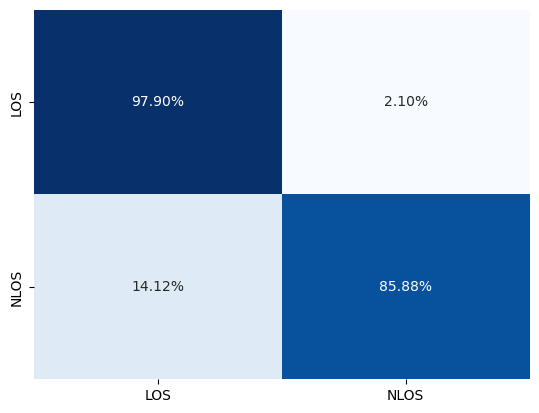

In [342]:
y_prob = stacking_classifier.predict_proba(X_test)
    
    # Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1], drop_intermediate = True)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]
    # Calculate AUC
y_pred = (y_prob[:, 1] >= optimal_threshold).astype(int)  # Assuming binary classification
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(cm, annot=True,  cbar = False, cmap="Blues", fmt=".2%", xticklabels=class_names, yticklabels=class_names)

FINISHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH ---> NEW codes for novel ideas will be added after this breakpoint reminder 